In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

In [12]:
# Load the datasets
train_df = pd.read_csv("C:/car_price/dataset/train.csv")
test_df = pd.read_csv("C:/car_price/dataset/test.csv")


In [13]:
# Preview both datasets
print("Train Dataset Preview:")
print(train_df.head())

print("\nTest Dataset Preview:")
print(test_df.head())

Train Dataset Preview:
           model  year motor_type        running wheel    color   type  \
0         toyota  2022     petrol       3000  km  left  skyblue  sedan   
1  mercedes-benz  2014     petrol     132000  km  left    black  sedan   
2            kia  2018     petrol   95000  miles  left    other  sedan   
3  mercedes-benz  2002     petrol  137000  miles  left   golden  sedan   
4  mercedes-benz  2017     petrol     130000  km  left    black  sedan   

      status  motor_volume  price  
0  excellent           2.0  24500  
1  excellent           2.0  25500  
2  excellent           2.0  11700  
3  excellent           3.2  12000  
4       good           2.0  26000  

Test Dataset Preview:
   Id          model  year motor_type       running wheel   color       type  \
0   0            kia  2020     petrol     24000  km  left   black      sedan   
1   1         nissan  2017     petrol  85000  miles  left   white        suv   
2   2        hyundai  2021     petrol  30000  miles  

In [14]:
# Preprocess the 'running' column: Convert miles to km

def distance_to_km(distance_str):
    cleaned_str = distance_str.lower().replace(",", "").strip()

    if "miles" in cleaned_str:
        distance_km = float(cleaned_str.replace("miles", "").strip()) * 1.60934  # Convert miles to km
    elif "km" in cleaned_str:
        distance_km = float(cleaned_str.replace("km", "").strip())
    else:
        distance_km = np.nan

    return distance_km


train_df["running"] = train_df["running"].apply(distance_to_km)
test_df["running"] = test_df["running"].apply(distance_to_km)

# Display output
print("Train Dataset - Processed 'running' Column:")
print(train_df[['running']].head())  # Display only the 'running' column

print("\nTest Dataset - Processed 'running' Column:")
print(test_df[['running']].head())  # Display only the 'running' column


Train Dataset - Processed 'running' Column:
     running
0    3000.00
1  132000.00
2  152887.30
3  220479.58
4  130000.00

Test Dataset - Processed 'running' Column:
     running
0   24000.00
1  136793.90
2   48280.20
3   85295.02
4  230000.00


In [15]:
# Drop the 'Id' column in the test dataset since it's not needed for prediction
test_df = test_df.drop(columns=['Id'])

# Display output
print("Updated Test Dataset (After Dropping 'Id' Column):")
print(test_df.head())  # Display first 5 rows of test dataset

Updated Test Dataset (After Dropping 'Id' Column):
           model  year motor_type    running wheel   color       type  \
0            kia  2020     petrol   24000.00  left   black      sedan   
1         nissan  2017     petrol  136793.90  left   white        suv   
2        hyundai  2021     petrol   48280.20  left   white      sedan   
3            kia  2018     petrol   85295.02  left  silver      sedan   
4  mercedes-benz  2003     petrol  230000.00  left   black  Universal   

      status  motor_volume  
0  excellent           2.0  
1  excellent           2.0  
2  excellent           2.0  
3  excellent           2.0  
4     normal           1.8  


In [16]:
# Handle categorical variables by encoding them using LabelEncoder
categorical_columns = ['model', 'motor_type', 'wheel', 'color', 'type', 'status']

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    # Fit on both train and test data combined
    le.fit(pd.concat([train_df[col], test_df[col]], axis=0))
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

In [17]:
# Display encoded output
print("Train Dataset - Encoded Categorical Columns:")
print(train_df.head())  # Show first 5 rows of categorical columns

print("\nTest Dataset - Encoded Categorical Columns:")
print(test_df.head())  # Show first 5 rows of categorical columns

Train Dataset - Encoded Categorical Columns:
   model  year  motor_type    running  wheel  color  type  status  \
0      4  2022           3    3000.00      0     15     5       1   
1      2  2014           3  132000.00      0      1     5       1   
2      1  2018           3  152887.30      0     10     5       1   
3      2  2002           3  220479.58      0      6     5       1   
4      2  2017           3  130000.00      0      1     5       2   

   motor_volume  price  
0           2.0  24500  
1           2.0  25500  
2           2.0  11700  
3           3.2  12000  
4           2.0  26000  

Test Dataset - Encoded Categorical Columns:
   model  year  motor_type    running  wheel  color  type  status  \
0      1  2020           3   24000.00      0      1     5       1   
1      3  2017           3  136793.90      0     16     6       1   
2      0  2021           3   48280.20      0     16     5       1   
3      1  2018           3   85295.02      0     14     5       1   


In [18]:
# Compute Interquartile Range (IQR)
q1, q3 = np.percentile(train_df["price"], [25, 75])
iqr_range = q3 - q1

# Define bounds for outlier detection
lower_limit = q1 - 1.5 * iqr_range
upper_limit = q3 + 1.5 * iqr_range

# Cap outliers at the upper bound
train_df["price_adjusted"] = train_df["price"].clip(lower=lower_limit, upper=upper_limit)

# Display statistics
train_df[["price", "price_adjusted"]].describe()


,price,price_adjusted
count,1642.000000,1642.000000
mean,15982.633374,15635.915956
std,7176.084647,6059.701114
min,462.000000,2250.000000
25%,12000.000000,12000.000000
50%,15750.000000,15750.000000
75%,18500.000000,18500.000000
max,87000.000000,28250.000000


In [19]:
features = train_df.drop(columns=['price', 'price_adjusted'])
target = train_df['price_adjusted']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [20]:
# Train the model using Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

In [21]:
# Predict on the train dataset
y_pred = rf.predict(X_test)

In [22]:
# Evaluate the model by calculating the Mean Absolute Error (MAE) on train data
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [23]:
# Print accuracy metrics on the training data
print(f"Mean Absolute Error : {mae}")
print(f"Mean Squared Error : {mse}")
print(f"R^2 Score : {r2}")


Mean Absolute Error : 1886.474466637719
Mean Squared Error : 8685927.595412927
R^2 Score : 0.7538473998399393


In [24]:
# Save the trained model to the specified path
model_path = "C:/car_price/model/random_forest_model.pkl"
joblib.dump(rf, model_path)


['C:/car_price/model/random_forest_model.pkl']

In [25]:
# Make predictions on the test dataset
test_predictions = rf.predict(test_df)

In [26]:
# Save the predictions to a CSV file for Kaggle submission
submission = pd.DataFrame({
    'Id': test_df.index,
    'price': test_predictions.round(0).astype(int)
})

submission.to_csv("C:/car_price/dataset/submission.csv", index=False)

print("Model training complete, model saved, and submission file saved successfully!")

Model training complete, model saved, and submission file saved successfully!


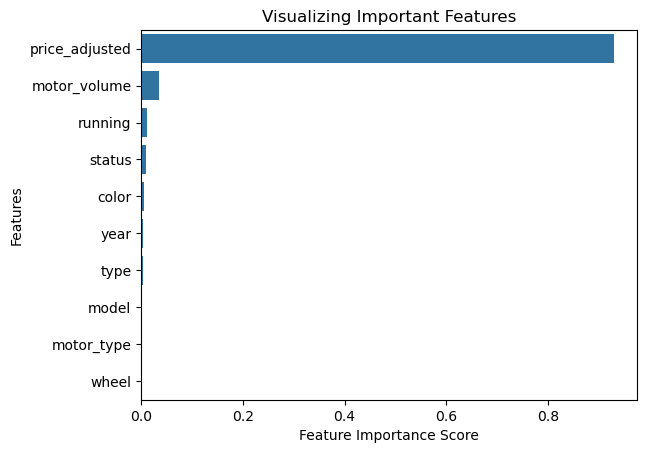

In [38]:
# Assuming the model is already trained and 'train_df' is your dataset

# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for visualization (excluding 'price' column)
feature_scores = pd.DataFrame({
    'Feature': train_df.drop(columns=['price']).columns,  # Exclude target 'price'
    'Importance': feature_importances
})

# Sort the values based on importance
feature_scores = feature_scores.sort_values(by='Importance', ascending=False)

# Create seaborn bar plot
sns.barplot(x='Importance', y='Feature', data=feature_scores)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

# Add title to the graph
plt.title('Visualizing Important Features')

# Visualize the graph
plt.show()